In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
import gc
import librosa

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive')

In [4]:
tracks = pd.read_csv('tracks.csv')
tracks.columns = tracks.iloc[0]
tracks = tracks.drop([0, 1])
new_cols = tracks.columns.values
new_cols[0] = 'track_id'
tracks.columns = new_cols
tracks = tracks.reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
mfcc = pickle.load(open('mel-spec.pkl', 'rb'))
gc.collect()
mfcc[0]

array([[-65.062225, -47.759476, -44.176395, ..., -39.408173, -41.73693 ,
        -29.414968],
       [-65.40291 , -52.760864, -49.179825, ..., -16.405546, -16.314037,
        -17.623047],
       [-69.48193 , -56.67646 , -50.5069  , ..., -16.358839, -16.07241 ,
        -18.654762],
       ...,
       [-79.42308 , -59.74297 , -36.38287 , ..., -46.371128, -42.364655,
        -50.543457],
       [-80.      , -63.4197  , -41.733234, ..., -50.3838  , -46.90663 ,
        -58.020092],
       [-80.      , -73.82068 , -52.945995, ..., -63.188034, -56.469955,
        -67.65623 ]], dtype=float32)

In [6]:
mfcc[0].shape

(128, 646)

In [0]:
mfcc_df = pd.DataFrame(mfcc)
index_nan = np.argwhere(pd.isnull(mfcc))

In [8]:
mfcc_df = mfcc_df.dropna()
mfcc = mfcc_df.to_numpy().ravel()

max_dim = 0
for i in mfcc:
    if i.shape[1] > max_dim:
        max_dim = i.shape[1]
    else:
        pass
print(max_dim)

647


In [0]:
for i in range(len(mfcc)):
    mfcc[i] = np.append(mfcc[i], np.zeros((128, max_dim - mfcc[i].shape[1])), axis=1)
    mfcc[i] = librosa.util.normalize(mfcc[i])
    
index_nan = index_nan.ravel()

In [10]:
mfcc[0].shape

(128, 647)

In [0]:
del mfcc_df

In [12]:
gc.collect()

0

In [0]:
tracks = tracks.loc[tracks['subset'] == 'small']
tracks = tracks.reset_index()
tracks = tracks.drop(index_nan)
tracks = tracks.reset_index()

In [0]:
y_train = tracks.loc[(tracks['split'] == 'training')]['genre_top']
y_val = tracks.loc[(tracks['split'] == 'validation')]['genre_top']
y_test = tracks.loc[(tracks['split'] == 'test')]['genre_top']

In [16]:
index_train = y_train.index
index_val = y_val.index
index_test = y_test.index
print(index_train)
print(index_val)
print(index_test)

Int64Index([   0,    1,    2,    3,    4,    7,    8,    9,   10,   11,
            ...
            7981, 7982, 7983, 7984, 7985, 7986, 7987, 7994, 7995, 7996],
           dtype='int64', length=6397)
Int64Index([   5,   23,   28,   36,   58,   70,  117,  122,  126,  127,
            ...
            7854, 7855, 7856, 7857, 7858, 7859, 7860, 7869, 7871, 7928],
           dtype='int64', length=800)
Int64Index([   6,   39,   40,   41,   42,   43,   44,   55,   56,   64,
            ...
            7951, 7952, 7964, 7965, 7988, 7989, 7990, 7991, 7992, 7993],
           dtype='int64', length=800)


In [17]:
len(y_train) + len(y_val) + len(y_test)

7997

In [18]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=8, dtype='int32')
y_val = tf.keras.utils.to_categorical(y_val, num_classes=8, dtype='int32')
y_test = tf.keras.utils.to_categorical(y_test, num_classes=8, dtype='int32')

gc.collect()

0

In [19]:
mfcc = np.stack(mfcc.ravel()).reshape(-1, 128, max_dim)
gc.collect()

0

In [20]:
mfcc.shape

(7997, 128, 647)

In [21]:
mfcc = mfcc.reshape((-1, 128, max_dim, 1))
mfcc.shape

(7997, 128, 647, 1)

In [22]:
mfcc[0].shape

(128, 647, 1)

In [0]:
X_train = mfcc[index_train]
X_val = mfcc[index_val]
X_test = mfcc[index_test]

In [24]:
len(X_train)

6397

In [25]:
y_train.shape

(6397, 8)

In [26]:
X_train[0]

array([[[-0.81327782],
        [-0.64696609],
        [-0.81883592],
        ...,
        [-0.73909977],
        [-0.43477104],
        [ 0.        ]],

       [[-0.81753635],
        [-0.7147166 ],
        [-0.91157748],
        ...,
        [-0.28889765],
        [-0.2604793 ],
        [ 0.        ]],

       [[-0.86852417],
        [-0.76775859],
        [-0.93617563],
        ...,
        [-0.28461879],
        [-0.27572868],
        [ 0.        ]],

       ...,

       [[-0.99278851],
        [-0.80929857],
        [-0.67437826],
        ...,
        [-0.75021583],
        [-0.7470629 ],
        [ 0.        ]],

       [[-1.        ],
        [-0.85910482],
        [-0.77355047],
        ...,
        [-0.83064757],
        [-0.85757209],
        [ 0.        ]],

       [[-1.        ],
        [-1.        ],
        [-0.9813857 ],
        ...,
        [-1.        ],
        [-1.        ],
        [ 0.        ]]])

Train on 5757 samples, validate on 640 samples
Epoch 1/50
5757/5757 [==============================] - 6s 1ms/step - loss: 2.5715 - categorical_accuracy: 0.1431 - val_loss: 2.4838 - val_categorical_accuracy: 0.1609

Epoch 00001: val_categorical_accuracy improved from -inf to 0.16094, saving model to best_model_cnn_mel-spec.hdf5
Epoch 2/50
5757/5757 [==============================] - 6s 1ms/step - loss: 2.3896 - categorical_accuracy: 0.2255 - val_loss: 2.3387 - val_categorical_accuracy: 0.2438

Epoch 00002: val_categorical_accuracy improved from 0.16094 to 0.24375, saving model to best_model_cnn_mel-spec.hdf5
Epoch 3/50
5757/5757 [==============================] - 6s 1ms/step - loss: 2.2137 - categorical_accuracy: 0.3021 - val_loss: 2.1556 - val_categorical_accuracy: 0.3031

Epoch 00003: val_categorical_accuracy improved from 0.24375 to 0.30312, saving model to best_model_cnn_mel-spec.hdf5
Epoch 4/50
5757/5757 [==============================] - 6s 1ms/step - loss: 2.0880 - categorical_a

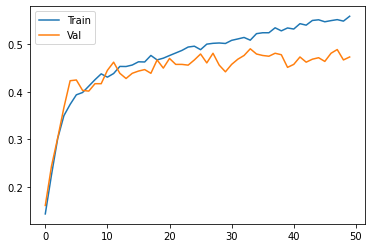

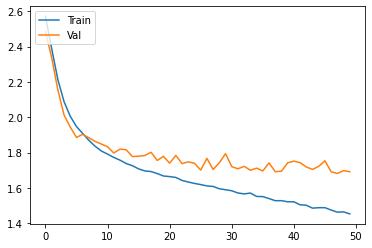

Train:
[1.5480831103602928, 0.527747392654419]
Val:
[1.6464787340164184, 0.45625001192092896]


In [29]:
activation='relu'
optimizer = keras.optimizers.Adam(lr=0.0001)
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(32, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Conv2D(32, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=1)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=50, verbose=1, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

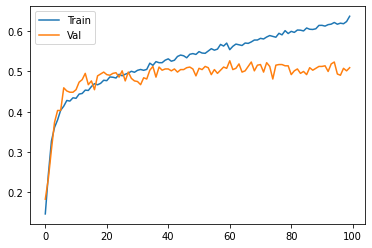

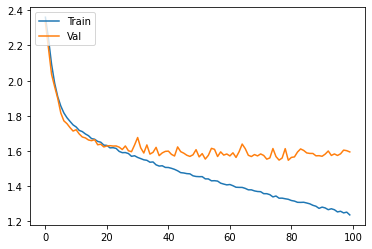

Train:
[1.396542966598754, 0.5757386088371277]
Val:
[1.5793553924560546, 0.49125000834465027]


In [31]:
activation='relu'
optimizer = keras.optimizers.Adam(lr=0.0001)
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(16, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Conv2D(16, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=0, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

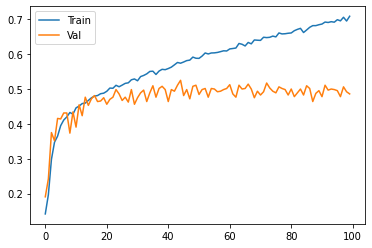

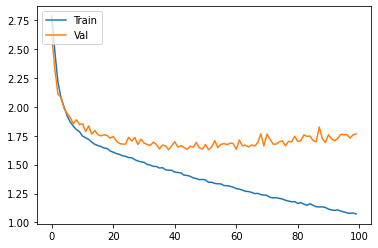

Train:
[1.384960632725248, 0.5944974422454834]
Val:
[1.641326379776001, 0.45124998688697815]


In [32]:
activation='relu'
optimizer = keras.optimizers.Adam(lr=0.0001)
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(64, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Conv2D(64, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=0, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

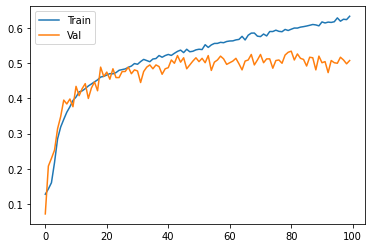

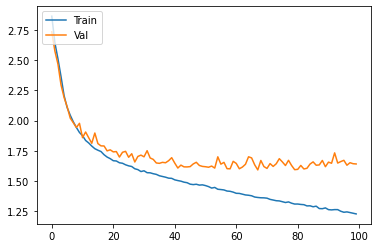

Train:
[1.2937339757110098, 0.6137251853942871]
Val:
[1.6071334314346313, 0.4712499976158142]


In [33]:
activation='relu'
optimizer = keras.optimizers.Adam(lr=0.0001)
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(64, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dropout(0.5))
model.add(Conv2D(64, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dropout(0.5))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=0, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

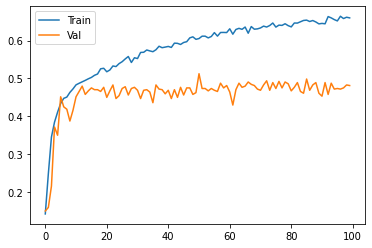

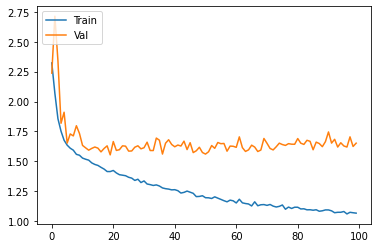

Train:
[1.1999250490515982, 0.630608081817627]
Val:
[1.6504947710037232, 0.4449999928474426]


In [34]:
activation='relu'
optimizer = keras.optimizers.Adam()
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(16, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dropout(0.5))
model.add(Conv2D(16, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dropout(0.5))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=0, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

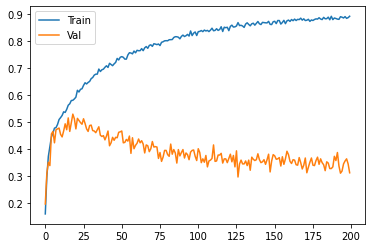

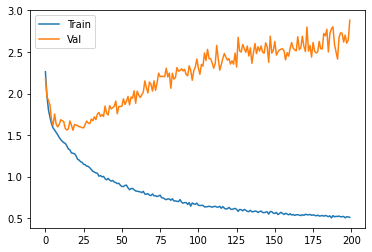

Train:
[1.3438706623496013, 0.5632327795028687]
Val:
[1.6057483673095703, 0.4975000023841858]


In [37]:
activation='relu'
optimizer = keras.optimizers.Adam()
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(16, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dropout(0.5))
model.add(Conv2D(16, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dropout(0.5))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=200, verbose=0, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

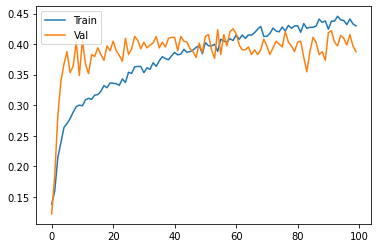

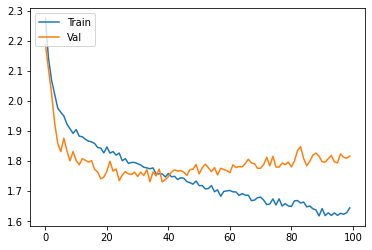

Train:
[1.589223384279487, 0.4758480489253998]
Val:
[1.82178560256958, 0.32624998688697815]


In [36]:
from keras.layers import SpatialDropout2D

activation='relu'
optimizer = keras.optimizers.Adam()
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(16, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(SpatialDropout2D(0.5))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Conv2D(16, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(SpatialDropout2D(0.5))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=0, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

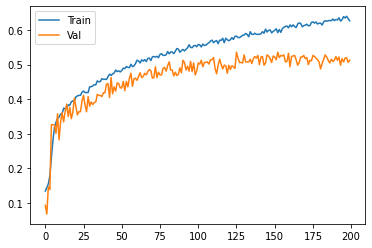

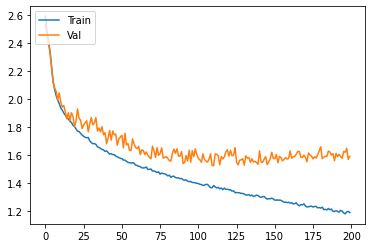

Train:
[1.3203800516760646, 0.5865249037742615]
Val:
[1.5341482257843018, 0.4650000035762787]


In [41]:
activation='relu'
optimizer = keras.optimizers.Adam(lr=0.001)
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(32, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dropout(0.5))
model.add(Conv2D(32, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dropout(0.5))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=50, verbose=1, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

Train on 5757 samples, validate on 640 samples
Epoch 1/100
5757/5757 [==============================] - 8s 1ms/step - loss: 2.3602 - categorical_accuracy: 0.1503 - val_loss: 2.2296 - val_categorical_accuracy: 0.1703
Epoch 2/100
5757/5757 [==============================] - 8s 1ms/step - loss: 2.1452 - categorical_accuracy: 0.1994 - val_loss: 2.0417 - val_categorical_accuracy: 0.2812
Epoch 3/100
5757/5757 [==============================] - 8s 1ms/step - loss: 2.0365 - categorical_accuracy: 0.2430 - val_loss: 1.9332 - val_categorical_accuracy: 0.3594
Epoch 4/100
5757/5757 [==============================] - 8s 1ms/step - loss: 1.9772 - categorical_accuracy: 0.2644 - val_loss: 1.8280 - val_categorical_accuracy: 0.3703
Epoch 5/100
5757/5757 [==============================] - 8s 1ms/step - loss: 1.9594 - categorical_accuracy: 0.2774 - val_loss: 1.8523 - val_categorical_accuracy: 0.3938
Epoch 6/100
5757/5757 [==============================] - 8s 1ms/step - loss: 1.9377 - categorical_accuracy: 

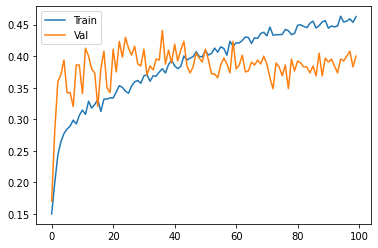

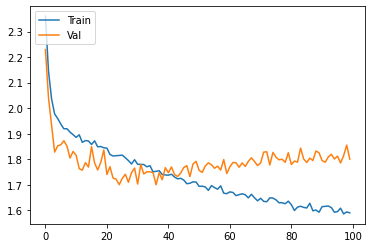

Train:
[1.6102663179813221, 0.4517742693424225]
Val:
[1.756848497390747, 0.35499998927116394]


In [43]:
activation='relu'
optimizer = keras.optimizers.Adam(lr=0.001)
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(32, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(SpatialDropout2D(0.5))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Conv2D(32, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(SpatialDropout2D(0.5))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=1, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

In [0]:
activation='relu'
optimizer = keras.optimizers.Adam(lr=0.0001)
metrics=['categorical_accuracy']

model = keras.Sequential()
model.add(Conv2D(16, kernel_size=3, kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation, input_shape=(128, max_dim, 1)))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dropout(0.5))
model.add(Conv2D(16, kernel_size=(3,5), kernel_regularizer=keras.regularizers.l2(), strides=1, activation=activation))
model.add(MaxPool2D(pool_size=(2,4)))
model.add(Dropout(0.5))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l2(), activation=activation))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=200, verbose=0, callbacks=[mcp_save])
plt.plot(history.history['' + metrics[0]])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))